# Introduction
This notebook contains experiments that benchmark and compare models described in recent computer vision literature. We focus on a simple classification task with a classical dataset (MNIST) [1].

Three base models are explored: Spatial transformer networks [2], vision transformers [3], and SpinalNets [4]. We also implement new variations for two of three of these models, by replacing standard convolutional layers by CoordConv layers [5].

*   Spatial transformer networks (STN)
*   Spatial transformer networks + CoordConv layers
*   Vision transformers
*   SpinalNet
*   SpinalNet + STN + CoordConv layers

A model comparison table is shown at the end of the notebook, including training details and hyperparameters.



# Setup

We begin by cloning the repository containing all the necessary models and modules. If running locally, there is no need to run this cell.

In [ ]:
!git clone https://github.com/manuel-munoz-aguirre/mnist-benchmark.git
!cp mnist-benchmark/*.py .

The only additional dependency needed (when running in Colab) is `pytorch_lightning`. We will use it to streamline the experiments and metric logging. If running locally, please see the `requirements.txt` file to ensure all the necessary dependencies are present.

In [6]:
!pip install pytorch_lightning

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import torch
import torchvision
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from six.moves import urllib
from torchvision import datasets, transforms

from STN import SimpleSTN, CoordConvSTN
from spinal import SpinalNet, SpinalNetCoordConv
from vit import ViT
from utils import plot_metric, convert_image_np, compare_stns, plot_wrong_preds
pl.utilities.seed.seed_everything(1) 

Global seed set to 1


1

# Data preparation
We begin by creating training and validation dataloaders for MNIST (the original `test` MNIST partition is used as validation in this notebook) with a batch size of 64. The training set is shuffled and will be evaluated in the same order for all the models (this is handled by pytorch-lightning, since the seed will be reset while training each model).

In [ ]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=2)

# Validation dataset
validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Model training
If a GPU is available, it will be used (this notebook was run with a GPU available). We run each model for a maximum of 20 epochs. To train the models, we will use an early stopping criteria on the `validation_loss` (for the epoch), requiring a minimum delta improvement of `0.005` from the best loss observed so far. If no improvement is seen for 5 epochs, training will be stopped. This criteria is the same for all the models.

For a fair comparison, all the models will be trained with SGD with a learning rate of `0.01` and negative log-likelihood loss. However, we should point out that other optimizer settings might give better results for more complex models, like in the case of Vision Transformers.

Model comparison will be performed after all the models are trained.



In [ ]:
# Set the device. If there is a GPU available, use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpus = 1 if torch.cuda.is_available() else 0
max_epochs = 20
min_delta = 0.005
patience = 5

## Baseline spatial transformer network (STN)
In standard CNNs, a certain degree of spatial invariance is achieved through the usage of max-pooling. However, the extent of this invariance is limited, and for that reason, techniques such as data augmentation with image transformations are often applied in order to make the model more robust to affine transformations that could occur in the data, such as scaling and rotation. Jaderberg et al. [1] point out that CNNs:

<blockquote>
"[...] are not
actually invariant to large transformations of the input data [...] due
to having only a limited, pre-defined pooling mechanism for dealing with variations in the spatial
arrangement of data."
</blockquote>

For this reason, they propose *Spatial Transformers*, which is a drop-in module that can be easily included in many types of models in order to learn dynamic spatial transformations (scaling, cropping, rotations and non-rigid deformations) of the input data that help in minimizing the loss. As a consequence, this module can play the role of 1) an attention mechanism and, 2) a transformer of the input data into an expected canonical pose that simplifies learning. An advantage of STNs is that they require few parameters and are thus fast. 

Briefly, a spatial transformer is composed of three components:

1.   A localization network: implicitly learns from the data a set of parameters $\theta$ for a given transformation to be applied to the input feature map.
2.   A grid generator: with the learned parameters, a set of points (sampling grid) is generated for the input feature map, in order to map it to a transformed output.
3.   A sampler: takes the input feature map and the sampling grid in order to apply the transformation.

We will train a simple CNN with a Spatial Transformer Network module at the beginning of the forward function.

In [ ]:
baseline_stn_model = SimpleSTN(lr = 0.01)
baseline_logger = TensorBoardLogger("logs", name="baseline_STN")
baseline_early_stop_callback = EarlyStopping(monitor="validation_loss", 
                                             min_delta=min_delta,
                                             patience=patience, 
                                             verbose=True, 
                                             mode="min")

In [ ]:
baseline_trainer = pl.Trainer(logger=baseline_logger,
                              callbacks=[baseline_early_stop_callback],
                              gpus=gpus,
                              min_epochs=1,
                              max_epochs=max_epochs,
                              deterministic=True)
baseline_trainer.fit(baseline_stn_model, 
                     train_dataloaders=train_loader, 
                     val_dataloaders=validation_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)

  | Name                | Type       | Params | In sizes         | Out sizes       
-----------------------------------------------------------------------------------------
0 | train_accuracy      | Accuracy   | 0      | ?                | ?               
1 | validation_accuracy | Accuracy   | 0      | ?                | ?               
2 | conv1               | Conv2d     | 260    | [64, 1, 28, 28]  | [64, 10, 24, 24]
3 | conv2         

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 0.404


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.296 >= min_delta = 0.005. New best score: 0.108


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.019 >= min_delta = 0.005. New best score: 0.089


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.081


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.014 >= min_delta = 0.005. New best score: 0.067


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.010 >= min_delta = 0.005. New best score: 0.057


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.040


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

The model trains for 20 epochs (count is zero-based) and reaches a validation accuracy of 98.77% and a loss of 0.0402. As is usual with MNIST, the loss starts converging quite quickly.


In [ ]:
print("Validation accuracy = %.04f and loss = %.04f at epoch %d" %
      (baseline_trainer.logged_metrics['validation_acc'], 
       baseline_trainer.logged_metrics['validation_loss'], 
       baseline_trainer.logged_metrics['epoch']))

Validation accuracy = 0.9877 and loss = 0.0402 at epoch 19


(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d4977a3d0>)

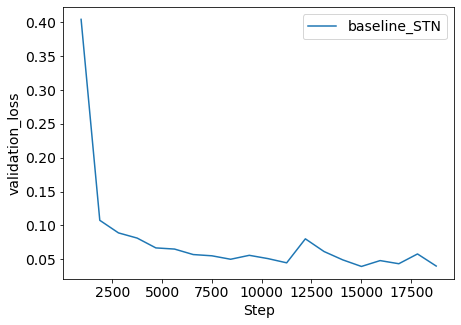

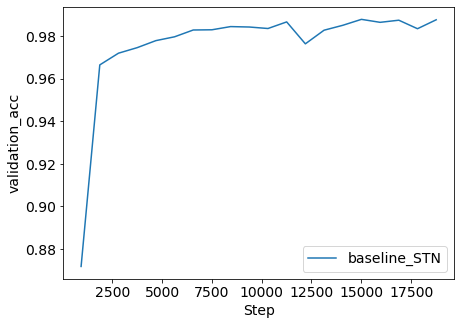

In [ ]:
plot_metric(paths=['logs/baseline_STN/version_0/'],
            names=["baseline_STN"],
            key="validation_loss")
plot_metric(paths=['logs/baseline_STN/version_0/'],
            names=["baseline_STN"],
            key="validation_acc")

## Spatial transformer network with CoordConv layers

Liu et al. [5] expose that vanilla stacks of convolutional layers fail on the simple problem of performing a mapping from a Cartesian representation to a pixel-based representation and viceversa, and propose the concept of a CoordConv layer:

<blockquote>
"[...] which works by giving convolution access to its own input coordinates through the use of extra coordinate channels."
</blockquote>

For the case of MNIST, this means mapping a tensor of shape (C=1, H=28, W=28) to (C=3, H=28, W=28), where the two extra channels contain untrained constant positional coordinates (i, j) for each of the tensor entries, with these coordinates linearly scaled between [-1, 1]. The advantage of CoordConv is that it allows to control the degree of translation dependence according to the task to be solved.

The baseline STN model presented in the previous section contains convolutional layers both in the forward function as well as in the localization network. In the following two subsections, the forward pass convolutions are replaced by CoordConv layer, but we make a distinction on whether CoordConv is also used within the localization network, and examine whether this has a noticeable effect on performance or not.

### Localization network without CoordConv
Train a model with CoordConv layers on the forward pass but **not** on the STN localization network.

In [ ]:
coordconv_noloc_model = CoordConvSTN(lr = 0.01, coordconv_localization=False)
coordconv_noloc_logger = TensorBoardLogger("logs", name="CoordConv_noloc_STN")
coordconv_noloc_early_stop_callback = EarlyStopping(monitor="validation_loss", 
                                                    min_delta=min_delta, 
                                                    patience=patience, 
                                                    verbose=True, 
                                                    mode="min")

In [ ]:
coordconv_noloc_trainer = pl.Trainer(logger=coordconv_noloc_logger,
                                     callbacks=[coordconv_noloc_early_stop_callback],
                                     gpus=gpus,
                                     min_epochs=1,
                                     max_epochs=max_epochs,
                                     deterministic=True)
coordconv_noloc_trainer.fit(coordconv_noloc_model, 
                            train_dataloaders=train_loader, 
                            val_dataloaders=validation_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type       | Params | In sizes         | Out sizes       
-----------------------------------------------------------------------------------------
0 | train_accuracy      | Accuracy   | 0      | ?                | ?               
1 | validation_accuracy | Accuracy   | 0      | ?                | ?               
2 | coordconv1          | CoordConv  | 760    | [64, 1, 28, 28]  | [64, 10, 24, 24]
3 | coordconv2          | CoordConv  | 6.0 K  | [64, 10, 12, 12] | [64, 20, 8, 8]  
4 | coordconv2_drop     | Dropout2d  | 0      | [64, 20, 8, 8]   | [64, 20, 8, 8]  
5 | fc1                 | Linear     | 16.1 K | [64, 320]        | [64, 50]        
6 | fc2                 | Linear     | 510    | [64, 50]         | [64, 10]        
7 | localization        | Sequential | 2.4 K  | [64, 1, 28, 28]  | [64, 10, 3, 3]  
8 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 0.681


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.546 >= min_delta = 0.005. New best score: 0.134


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.047 >= min_delta = 0.005. New best score: 0.087


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.018 >= min_delta = 0.005. New best score: 0.069


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.010 >= min_delta = 0.005. New best score: 0.058


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.052


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 5 records. Best score: 0.052. Signaling Trainer to stop.


In [ ]:
print("Validation accuracy = %.04f and loss = %.04f at epoch %d" %
      (coordconv_noloc_trainer.logged_metrics['validation_acc'], 
       coordconv_noloc_trainer.logged_metrics['validation_loss'], 
       coordconv_noloc_trainer.logged_metrics['epoch']))

Validation accuracy = 0.9825 and loss = 0.0564 at epoch 11


### Localization network with CoordConv
Train a model with CoordConv layers on the forward function **and** in the localization network.

In [ ]:
coordconv_stn_model = CoordConvSTN(lr = 0.01, coordconv_localization=True)
coordconv_logger = TensorBoardLogger("logs", name="CoordConv_STN")
coordconv_early_stop_callback = EarlyStopping(monitor="validation_loss", 
                                              min_delta=min_delta, 
                                              patience=patience, 
                                              verbose=True, 
                                              mode="min")

In [ ]:
coordconv_trainer = pl.Trainer(logger=coordconv_logger,
                               callbacks=[coordconv_early_stop_callback],
                               gpus=gpus,
                               min_epochs=1,
                               max_epochs=max_epochs,
                               deterministic=True)
coordconv_trainer.fit(coordconv_stn_model, 
                      train_dataloaders=train_loader, 
                      val_dataloaders=validation_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type       | Params | In sizes         | Out sizes       
-----------------------------------------------------------------------------------------
0 | train_accuracy      | Accuracy   | 0      | ?                | ?               
1 | validation_accuracy | Accuracy   | 0      | ?                | ?               
2 | coordconv1          | CoordConv  | 760    | [64, 1, 28, 28]  | [64, 10, 24, 24]
3 | coordconv2          | CoordConv  | 6.0 K  | [64, 10, 12, 12] | [64, 20, 8, 8]  
4 | coordconv2_drop     | Dropout2d  | 0      | [64, 20, 8, 8]   | [64, 20, 8, 8]  
5 | fc1                 | Linear     | 16.1 K | [64, 320]        | [64, 50]        
6 | fc2                 | Linear     | 510    | [64, 50]         | [64, 10]        
7 | localization        | Sequential | 3.7 K  | [64, 1, 28, 28]  | [64, 10, 3, 3]  
8 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 0.391


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.248 >= min_delta = 0.005. New best score: 0.143


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.032 >= min_delta = 0.005. New best score: 0.111


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.022 >= min_delta = 0.005. New best score: 0.089


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.012 >= min_delta = 0.005. New best score: 0.077


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.070


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.063


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.009 >= min_delta = 0.005. New best score: 0.054


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.010 >= min_delta = 0.005. New best score: 0.044


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 5 records. Best score: 0.044. Signaling Trainer to stop.


In [ ]:
print("Validation accuracy = %.04f and loss = %.04f at epoch %d" %
      (coordconv_trainer.logged_metrics['validation_acc'], 
       coordconv_trainer.logged_metrics['validation_loss'], 
       coordconv_trainer.logged_metrics['epoch']))

Validation accuracy = 0.9853 and loss = 0.0477 at epoch 17


The STN that includes CoordConv in the localization network (_CoordConv_STN_) achieves a slightly lower validation loss and higher accuracy, although at a later epoch than the model with no CoordConv on the localization network (_CoordConv_noloc_STN_). It is worth mentioning though that on the validation curves seen below, the latter model reaches better metrics from the start, and thus, the better performance of _CoordConv_STN_ might be just due to a longer training time.

Although the improvement in the metrics is minimal between these two, more exhaustive benchmarks on other types of data are likely necessary in order to determine if there is any real difference, probably training them for the same number of steps. An hypothesis could be that, since the STN already performs a transformation of the input, the degree of translation invariance provided by CoordConv could be minimal, and thus we don't observe a large performance difference.

For simplicity, from this point onwards, we will only compare the rest of the models with the model that includes CoordConv in the localization network (_CoordConv_STN_). When comparing this to the baseline STN (accuracy = 98.77%) from the previous section, we observe slightly lower accuracy (98.53%), likely because the coordinate information is not very helpful in the case of MNIST which contains only relatively simple transforms. Liu et al. [5] mention this while testing CoordConv over ImageNet:

<blockquote>
"As might be expected for tasks requiring straightforward translation
invariance, CoordConv does not help significantly when tested with image classification."
</blockquote>

(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d48b60e50>)

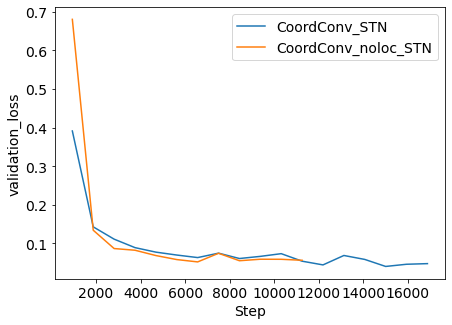

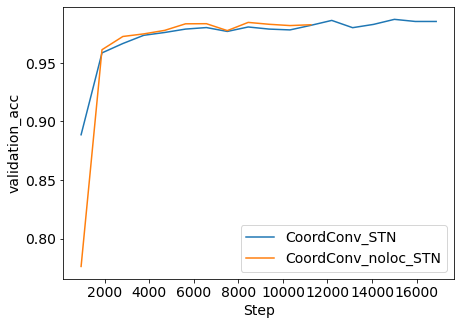

In [ ]:
plot_metric(paths=['logs/CoordConv_STN/version_0/', 
                   'logs/CoordConv_noloc_STN/version_0/'],
            names=["CoordConv_STN", "CoordConv_noloc_STN"],
            key="validation_loss")
plot_metric(paths=['logs/CoordConv_STN/version_0/', 
                   'logs/CoordConv_noloc_STN/version_0/'],
            names=["CoordConv_STN", "CoordConv_noloc_STN"],
            key="validation_acc")

## Vision transformers

Recent models that rely on _transformers_ (which are a type of self-attention modules) for natural language processing tasks have achieved state-of-the-art resutls. The usage of transformers has also been recently explored within the field of computer vision: an image is split into patches (analogous to tokens in NLP) and the linear embeddings of these patches are used as input for the transformer. Dosovitskiy et al. [3] show that vision transformers can perform as well as CNNs. 

This model architecture, although powerful, is large (at least compared to all the rest of the models in this notebook) and often benefits from pre-training, since this type of model tends to lack generalization with small amounts of data. In this line, it is worth considering that CNNs have inductive biases that transformers do not: for example, in transformers, since we work with sequences of patches, the relationships between these patches are "learned", while in CNNs there is an explicit notion of distance between the pixels. But since these patch sequences can be sparse, large amounts of data are needed to train successfully. As stated in [3]:

<blockquote>
"In CNNs, locality, two-dimensional neighborhood structure, and translation equivariance are baked into each layer throughout the whole model. In ViT, only MLP layers are local and translationally equivariant, while the self-attention layers are global [...] the position embeddings at initialization time carry no information about the 2D positions of the patches and all spatial relations between the patches have to be learned from scratch."
</blockquote>

For simplicity, here, we perform the training from scratch.

In [ ]:
# 28 x 28 = 4 7x7 patches
model_kwargs = {
        "embed_dim": 64,
        "hidden_dim": 128,
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": 7, 
        "num_channels": 1,
        "num_patches": 64,
        "num_classes": 10,
        "dropout": 0.2
        }
vit_model = ViT(model_kwargs, lr=0.01)
vit_logger = TensorBoardLogger("logs", name="ViT")
vit_early_stop_callback = EarlyStopping(monitor="validation_loss", 
                                        min_delta=min_delta, 
                                        patience=patience, 
                                        verbose=True, 
                                        mode="min")

In [ ]:
vit_trainer = pl.Trainer(logger=vit_logger,
                         callbacks=[vit_early_stop_callback],
                         gpus=gpus,
                         min_epochs=1,
                         max_epochs=max_epochs,
                         deterministic=True)
vit_trainer.fit(vit_model, 
                train_dataloaders=train_loader, 
                val_dataloaders=validation_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | In sizes        | Out sizes
--------------------------------------------------------------------------
0 | model | VisionTransformer | 209 K  | [64, 1, 28, 28] | [64, 10] 
--------------------------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.836     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.719


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.807 >= min_delta = 0.005. New best score: 0.912


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.409 >= min_delta = 0.005. New best score: 0.503


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.147 >= min_delta = 0.005. New best score: 0.355


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.069 >= min_delta = 0.005. New best score: 0.286


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.036 >= min_delta = 0.005. New best score: 0.250


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.029 >= min_delta = 0.005. New best score: 0.221


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.020 >= min_delta = 0.005. New best score: 0.202


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.016 >= min_delta = 0.005. New best score: 0.186


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.012 >= min_delta = 0.005. New best score: 0.173


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.009 >= min_delta = 0.005. New best score: 0.164


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.012 >= min_delta = 0.005. New best score: 0.152


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.012 >= min_delta = 0.005. New best score: 0.140


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.135


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.129


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.009 >= min_delta = 0.005. New best score: 0.121


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

With vision transformers, we train until the end without triggering early stopping and we see that the metrics are worse than all the other models we have run so far. This is expected, due to the points mentioned before.

In [ ]:
print("Validation accuracy = %.04f and loss = %.04f at epoch %d" %
      (vit_trainer.logged_metrics['validation_acc'], 
       vit_trainer.logged_metrics['validation_loss'], 
       vit_trainer.logged_metrics['epoch']))

Validation accuracy = 0.9641 and loss = 0.1189 at epoch 19


(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d481c3050>)

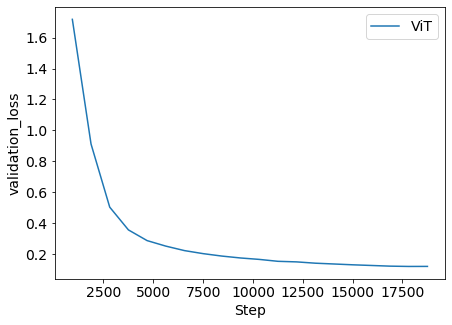

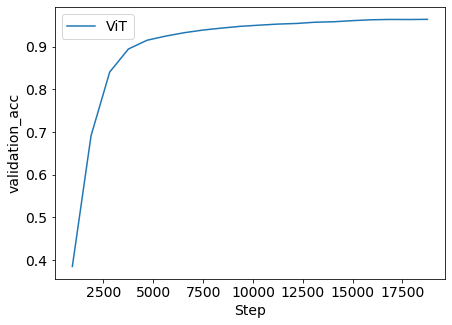

In [ ]:
plot_metric(paths=['logs/ViT/version_0/'],
            names=["ViT"],
            key="validation_loss")
plot_metric(paths=['logs/ViT/version_0/'],
            names=["ViT"],
            key="validation_acc")

## SpinalNet
This type of DNN is an interesting human-biology-inspired model proposed by Kabir et al. [4]. The authors state that SpinalNets benefit from:

<blockquote>

1. Gradual input
2. Local output and probable global influence
3. Weights reconfigured during training

</blockquote>

In SpinalNets, the input is sliced into parts (gradual input), and each part is fed to multiple hidden layers, with each hidden layer (local output) being also connected to the output of the previous layers (global influence). In practical terms, it aims to reduce issues such as the large number of parameters present in traditional deep CNN models, as well as other training issues such as vanishing gradients.

This type of model has achieved SOTA on STL-10 when coupled with a ResNet backbone (see [6]).

In [ ]:
spinal_logger = TensorBoardLogger("logs", name="SpinalNet")
spinal_early_stop_callback = EarlyStopping(monitor="validation_loss", 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=True, 
                                           mode="min")

spinal_trainer = pl.Trainer(logger=spinal_logger,
                            callbacks=[spinal_early_stop_callback],
                            gpus=gpus,
                            min_epochs=1,
                            max_epochs=max_epochs,
                            deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
spinal_model = SpinalNet(first_HL=8, lr=0.01)
spinal_trainer.fit(spinal_model, 
                   train_dataloaders=train_loader, 
                   val_dataloaders=validation_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type      | Params
---------------------------------------------------
0  | train_accuracy      | Accuracy  | 0     
1  | validation_accuracy | Accuracy  | 0     
2  | conv1               | Conv2d    | 260   
3  | conv2               | Conv2d    | 5.0 K 
4  | conv2_drop          | Dropout2d | 0     
5  | fc1                 | Linear    | 1.3 K 
6  | fc1_1               | Linear    | 1.4 K 
7  | fc1_2               | Linear    | 1.4 K 
8  | fc1_3               | Linear    | 1.4 K 
9  | fc1_4               | Linear    | 1.4 K 
10 | fc1_5               | Linear    | 1.4 K 
11 | fc2                 | Linear    | 490   
---------------------------------------------------
13.8 K    Trainable params
0         Non-trainable params
13.8 K    Total params
0.055     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 0.268


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.107 >= min_delta = 0.005. New best score: 0.161


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.038 >= min_delta = 0.005. New best score: 0.122


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.023 >= min_delta = 0.005. New best score: 0.100


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.015 >= min_delta = 0.005. New best score: 0.085


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.011 >= min_delta = 0.005. New best score: 0.074


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.009 >= min_delta = 0.005. New best score: 0.065


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.057


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 5 records. Best score: 0.045. Signaling Trainer to stop.


In [ ]:
print("Validation accuracy = %.04f and loss = %.04f at epoch %d" %
      (spinal_trainer.logged_metrics['validation_acc'], 
       spinal_trainer.logged_metrics['validation_loss'], 
       spinal_trainer.logged_metrics['epoch']))

Validation accuracy = 0.9863 and loss = 0.0410 at epoch 18


(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d481c3610>)

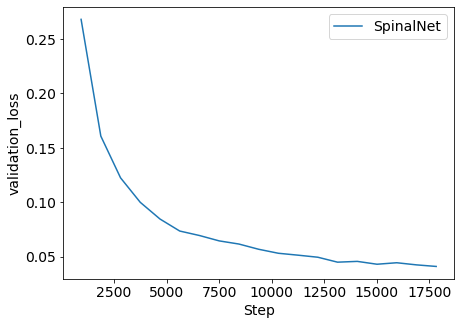

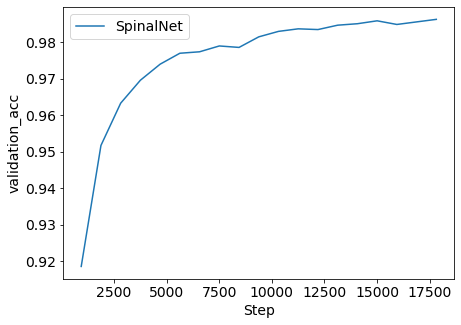

In [ ]:
plot_metric(paths=['logs/SpinalNet/version_0/'],
            names=["SpinalNet"],
            key="validation_loss")
plot_metric(paths=['logs/SpinalNet/version_0/'],
            names=["SpinalNet"],
            key="validation_acc")

## SpinalNet + STN + CoordConv
In this section, we perform a novel experiment with a combination of several concepts that we have explored so far: within a SpinalNet, we put a STN module at the beginning of the forward function, and replace standard convolutional layers in the rest of the forward pass with CoordConv layers (the localization network still uses standard convolutions). The idea of this would be to combine several attention mechanisms: the STN module would find a transformation for the input, and then this would be sliced into parts to be fed into the SpinalNet, which will compute local+global weights for each of these slices. Since the input is sliced, keeping the input coordinates (with CoordCond) could be useful.

In [ ]:
spinal_stnc_logger = TensorBoardLogger("logs", name="SpinalNet_STNCoordConv")
spinal_stnc_early_stop_callback = EarlyStopping(monitor="validation_loss",
                                                min_delta=min_delta, 
                                                patience=patience, 
                                                verbose=True, 
                                                mode="min")

spinal_stnc_trainer = pl.Trainer(logger=spinal_stnc_logger,
                                 callbacks=[spinal_stnc_early_stop_callback],
                                 gpus=gpus,
                                 min_epochs=1,
                                 max_epochs=max_epochs,
                                 deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
spinal_stnc_model = SpinalNetCoordConv(first_HL=8, lr=0.01)
spinal_stnc_trainer.fit(spinal_stnc_model, 
                        train_dataloaders=train_loader, 
                        val_dataloaders=validation_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type       | Params
----------------------------------------------------
0  | train_accuracy      | Accuracy   | 0     
1  | validation_accuracy | Accuracy   | 0     
2  | conv1               | CoordConv  | 760   
3  | conv2               | CoordConv  | 6.0 K 
4  | conv2_drop          | Dropout2d  | 0     
5  | fc1                 | Linear     | 1.3 K 
6  | fc1_1               | Linear     | 1.4 K 
7  | fc1_2               | Linear     | 1.4 K 
8  | fc1_3               | Linear     | 1.4 K 
9  | fc1_4               | Linear     | 1.4 K 
10 | fc1_5               | Linear     | 1.4 K 
11 | fc2                 | Linear     | 490   
12 | localization        | Sequential | 2.4 K 
13 | fc_loc              | Sequential | 3.1 K 
----------------------------------------------------
20.8 K    Trainable params
0         Non-trainable params
20.8 K    Total params
0.083     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 0.271


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.118 >= min_delta = 0.005. New best score: 0.153


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.071 >= min_delta = 0.005. New best score: 0.083


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.015 >= min_delta = 0.005. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.013 >= min_delta = 0.005. New best score: 0.055


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.014 >= min_delta = 0.005. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 5 records. Best score: 0.041. Signaling Trainer to stop.


In [ ]:
print("Validation accuracy = %.04f and loss = %.04f at epoch %d" %
      (spinal_stnc_trainer.logged_metrics['validation_acc'], 
       spinal_stnc_trainer.logged_metrics['validation_loss'], 
       spinal_stnc_trainer.logged_metrics['epoch']))

Validation accuracy = 0.9882 and loss = 0.0397 at epoch 15


(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d4843e0d0>)

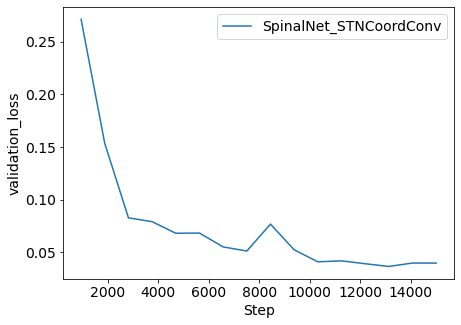

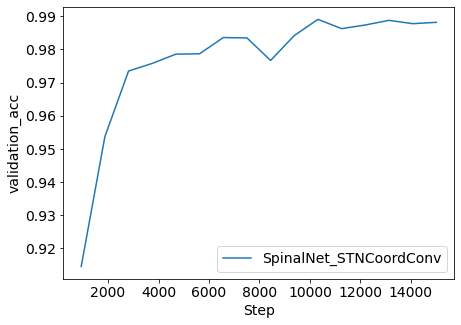

In [ ]:
plot_metric(paths=['logs/SpinalNet_STNCoordConv/version_0/'],
            names=["SpinalNet_STNCoordConv"],
            key="validation_loss")
plot_metric(paths=['logs/SpinalNet_STNCoordConv/version_0/'],
            names=["SpinalNet_STNCoordConv"],
            key="validation_acc")

# Model comparison and metrics

Below we show a comparison of the training loss at the step and epoch level (1 step = 1 batch) for each of the models. We observe that the vision transformer performs the worst: this is expected, since the model is quite complex in comparison to the rest in terms of the number of parameters. The current choice of optimizer and learning rate for this model is probably suboptimal as well, and would very likely benefit from tuning. Despite of this, vision transformers have already outperformed CNNs and are currently the state-of-the-art for CIFAR-10 [6], so it is definitely an interesting model, although its usage might be currently limited depending on the application domain, since it requires a lot of data to train. 

The rest of the models perform similarly and reach learning stability relatively fast, with the new proposed model (SpinalNet + STN + CoordConv) having a smaller loss and higher accuracy at a faster rate.

(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d46ae0250>)

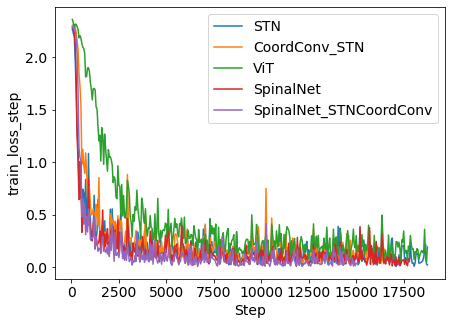

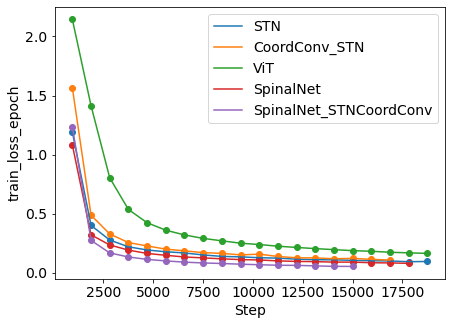

In [ ]:
logpaths = ['logs/baseline_STN/version_0/', 
            'logs/CoordConv_STN/version_0/', 
            'logs/ViT/version_0/',
            'logs/SpinalNet/version_0/',
            'logs/SpinalNet_STNCoordConv/version_0/']
lognames = ["STN", "CoordConv_STN", "ViT", "SpinalNet", "SpinalNet_STNCoordConv"]
plot_metric(paths=logpaths,
            names=lognames,
            key="train_loss_step")
plot_metric(paths=logpaths,
            names=lognames,
            key="train_loss_epoch", dot=True)

(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d468c8b50>)

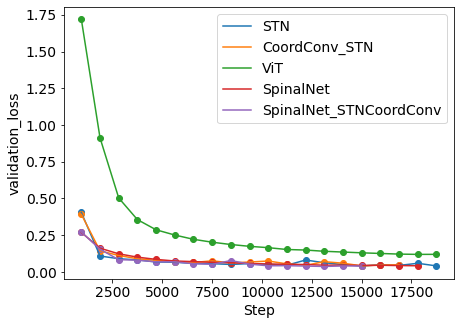

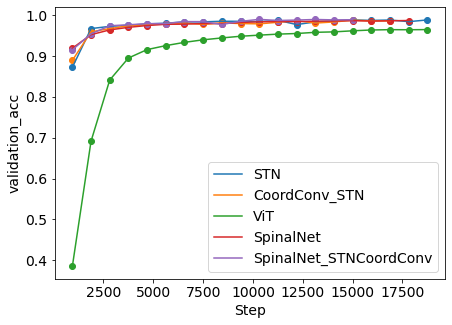

In [ ]:
plot_metric(paths=logpaths,
            names=lognames,
            key="validation_loss", dot=True)
plot_metric(paths=logpaths,
            names=lognames,
            key="validation_acc", dot=True)

As an additional exploration, we can look at the STN transformations learned by the baseline model (middle) and the CoordConv-STN model. The plot below shows the first batch of data from the validation set. We see that the baseline STN learns a transformation that, in some cases, attempts to shift the digits into what seems to be a canonical form (for example, the number 4 is transformed with a skew to the right). CoordConv-STN learns different transformations when compared to the baseline, but in most of the cases they are quite similar.

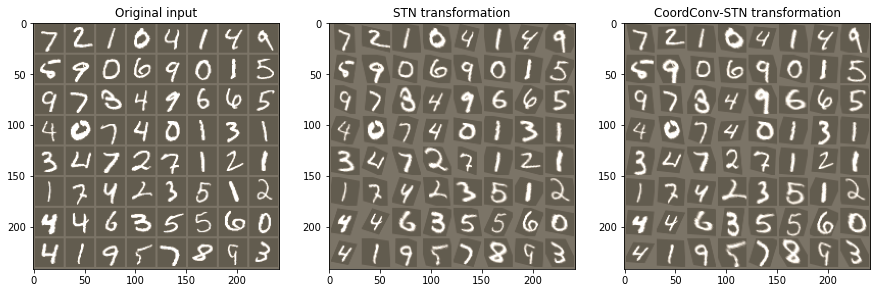

In [ ]:
baseline_stn_model.to(device)
coordconv_stn_model.to(device)
baseline_stn_model.eval()
coordconv_stn_model.eval()

compare_stns(baseline_stn_model, coordconv_stn_model, 
             'STN transformation', 'CoordConv-STN transformation',
             validation_loader, device)
plt.show()

We also look at the *top-k most wrongly predicted* instances according to the CoordConv-STN model (right) and plot the original data (left) and the transformation obtained by the baseline (middle) in order to try to understand what cases make CoordConv-STN fail. These instances are already difficult to distinguish correctly in the input data. At least visually, there are not many large changes on the baseline transformation, but the transformations of CoordConv-STN appear to be unstable (blurry) for these wrongly-predicted instances.

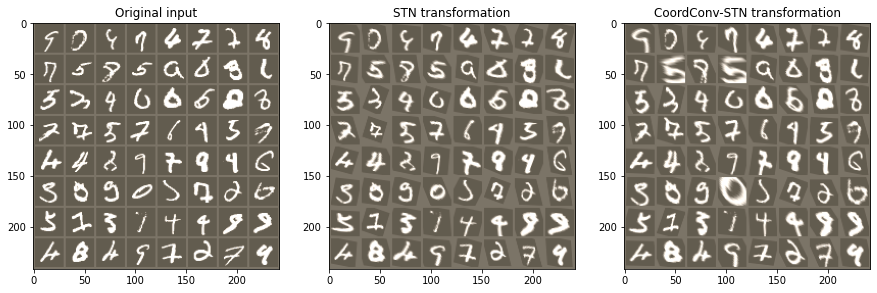

In [ ]:
plot_wrong_preds(baseline_stn_model, coordconv_stn_model, 
                 'STN transformation', 'CoordConv-STN transformation',
                 validation_loader, device, k=64)
plt.show()

We summarize the results of the experiments in the following table, with **SpinalNet + STN + CoordConv** performing the best in the validation set both in terms of accuracy and loss at an early stopping point (note that the stop epoch is zero-based).

In [ ]:
# Retrieve the metrics
logged_metrics = [baseline_trainer.logged_metrics, 
                  coordconv_trainer.logged_metrics,
                  vit_trainer.logged_metrics,
                  spinal_trainer.logged_metrics,
                  spinal_stnc_trainer.logged_metrics]
vaccs = [x['validation_acc'] for x in logged_metrics]
vloss = [x['validation_loss'] for x in logged_metrics]
vepoch = [x['epoch'] for x in logged_metrics]
tloss = [x['train_loss_epoch'] for x in logged_metrics]
trainable_params = [27.4, 30.1, 209, 13.8, 20.8]

# Store them in a dataframe
results = pd.DataFrame.from_records(zip(lognames, tloss, vaccs, vloss, 
                                        vepoch, trainable_params),
                          columns=['Model',
                                   'Train loss',
                                   'Validation acc.',
                                   'Validation loss',
                                   'Stop epoch',
                                   '#Params (K)'])
results.sort_values('Validation acc.', ascending=False)

,Model,Train loss,Validation acc.,Validation loss,Stop epoch,#Params (K)
4,SpinalNet_STNCoordConv,0.053142,0.9882,0.039704,15,20.8
0,STN,0.095177,0.9877,0.040174,19,27.4
3,SpinalNet,0.079475,0.9863,0.041040,18,13.8
1,CoordConv_STN,0.106751,0.9853,0.047722,17,30.1
2,ViT,0.163703,0.9641,0.118944,19,209.0


# Conclusion

Several of these experiments (the models relying on STNs and CoordConv) had a focus on learning transformations of the input data. MNIST is a good dataset for fast experimentation, but it might not be the best choice to benchmark the the extent of the improvement that these transformations can provide, since the input images are relatively simple with a limited degree of variation in terms of translation, rotation and scaling. These types of models might have a more interesting use in other domains such as facial recognition or OCR, where the instances can have high variability in terms of these transformations. These are not limited to the task of classification either, and can be of use for other learning types such as in generative models (for example, CoordConv helps prevent mode collapse [5]). When choosing a model for a real application, it is important to consider constraints such as runtime resources, limitations and available training data.

Perhaps unexpectedly, the SpinalNet + STN + CoordConv modification that is proposed here achieves a lower loss and higher validation accuracy at an earlier training point. This is an interesting finding, because it achieves good performance with a modest number of parameters. Further validation is necessary (including hyperparameter tuning) to evaluate wheter the proposed model has any significant advantages. 


# References

1.   Lecun, Y., et al. “Gradient-Based Learning Applied to Document Recognition.” Proceedings of the IEEE, vol. 86, no. 11, Nov. 1998, pp. 2278–324. IEEE Xplore, https://doi.org/10.1109/5.726791.
2.   Jaderberg, Max, et al. “Spatial Transformer Networks.” ArXiv:1506.02025 [Cs], Feb. 2016. arXiv.org, http://arxiv.org/abs/1506.02025.
3.   Dosovitskiy, Alexey, et al. An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale. Oct. 2020. arxiv.org, https://arxiv.org/abs/2010.11929v2.
4.   Kabir, H. M. Dipu, et al. “SpinalNet: Deep Neural Network with Gradual Input.” ArXiv:2007.03347 [Cs, Eess], Sept. 2020. arXiv.org, http://arxiv.org/abs/2007.03347.
5.   Liu, Rosanne, et al. An Intriguing Failing of Convolutional Neural Networks and the CoordConv Solution. July 2018. arxiv.org, https://arxiv.org/abs/1807.03247v2.
6. https://paperswithcode.com/task/image-classification

# Source code references
The following repositories and documents providing source code were adapted
or used as-is (more details are included within each module of this project).

*   Spatial Transformer Networks: https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html
*   CoordConv: https://github.com/uber-research/CoordConv/blob/master/CoordConv.py.
*   Vision transformers: https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/11-vision-transformer.html
*   SpinalNet: https://github.com/dipuk0506/SpinalNet/





